In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
sns.set(rc = {'figure.figsize':(10, 6)})
pd.set_option("precision", 3)

In [2]:
folder = "/home/jarobyte/scratch/guemes/icdar/nl/baseline/experiments/"

In [3]:
files = os.listdir(folder)
len(files)

25

In [4]:
logs = pd.concat([pd.read_csv(folder + f) 
                       for f in tqdm(os.listdir(folder))])\
.assign(dropout = lambda df: df.dropout.round(2))
print(logs.shape)
logs.head()

  0%|          | 0/25 [00:00<?, ?it/s]

(394, 21)


,epoch,train_loss,train_error_rate,dev_loss,dev_error_rate,training_minutes,learning_rate,weight_decay,model,max_sequence_length,...,feedforward_dimension,encoder_layers,decoder_layers,attention_heads,activation,dropout,parameters,encoder_tokens,decoder_tokens,experiment_id
0,1,0.908,25.580,0.719,20.472,10.124,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7535021,173,173,22717029_12
1,2,0.351,11.304,0.969,21.122,20.368,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7535021,173,173,22717029_12
2,3,0.147,5.353,1.349,21.617,30.615,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7535021,173,173,22717029_12
3,4,0.084,3.472,1.595,21.405,40.863,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7535021,173,173,22717029_12
4,5,0.065,2.934,1.749,21.350,51.110,1.000e-04,0.0,Transformer,110,...,1024,4,4,8,relu,0.0,7535021,173,173,22717029_12


In [5]:
experiments = logs\
.assign(fit = lambda df: df.apply(lambda r: {k:r[k] for k in ["train_loss", 
                                                              "dev_loss", 
                                                              "epoch"]}, 
                                  axis = 1))\
.groupby("experiment_id")\
.agg({"fit":(lambda x: min(x, key = lambda y: y["dev_loss"])),
      "parameters":max, 
      "dropout":max,
      "weight_decay":max,
      "embedding_dimension":max,
      "encoder_layers":max,
      "training_minutes":max})\
.assign(parameters = lambda df: df.parameters / 10**6, 
        train_loss = lambda df: df.fit.map(lambda x: x["train_loss"]),
        dev_loss = lambda df: df.fit.map(lambda x: x["dev_loss"]),
        epoch = lambda df: df.fit.map(lambda x: x["epoch"]))\
.drop(columns = "fit")
experiments.head(10)

,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
experiment_id,,,,,,,,,
22697242_1,7.535,0.4,1.000e-02,256,4,177.182,2.321,2.157,16
22697242_10,7.535,0.3,1.000e-04,256,4,175.600,0.512,0.584,10
22697242_11,7.535,0.2,1.000e-02,256,4,175.773,2.327,2.158,16
22697242_12,7.535,0.2,1.000e-04,256,4,178.108,0.468,0.583,8
22697242_2,7.535,0.1,1.000e-03,256,4,179.948,0.716,0.699,15
22697242_3,7.535,0.1,1.000e-02,256,4,179.880,2.320,2.153,16
22697242_4,7.535,0.3,1.000e-02,256,4,175.321,2.326,2.152,14
22697242_5,7.535,0.4,1.000e-02,256,4,181.285,2.333,2.164,15
22697242_6,7.535,0.4,1.000e-02,256,4,176.279,2.329,2.158,15


# evaluation

In [6]:
evaluation_folder = "/home/jarobyte/scratch/guemes/icdar/nl/baseline/evaluation/"

In [7]:
evaluation_files = os.listdir(evaluation_folder)
len(evaluation_files)

25

In [8]:
evaluation = pd.concat([pd.read_csv(evaluation_folder + f) 
                       for f in tqdm(os.listdir(evaluation_folder))])
print(evaluation.shape)
evaluation.head()

  0%|          | 0/25 [00:00<?, ?it/s]

(250, 9)


,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting
0,22717029_12,-12.603,disjoint,greedy,100,5.449,32.629,36.741,NaN
1,22717029_12,-15.099,disjoint,greedy,50,3.158,32.629,37.556,NaN
2,22717029_12,-22.803,disjoint,beam,100,24.824,32.629,40.069,NaN
3,22717029_12,-26.257,disjoint,beam,50,17.438,32.629,41.196,NaN
4,22717029_12,3.112,sliding,greedy,50,106.385,32.629,31.614,uniform


In [9]:
results = evaluation.merge(experiments, right_index = True, left_on = "experiment_id")\
.sort_values("improvement", ascending = False)
results.head(10)

,experiment_id,improvement,window,decoding,window_size,inference_seconds,cer_before,cer_after,weighting,parameters,dropout,weight_decay,embedding_dimension,encoder_layers,training_minutes,train_loss,dev_loss,epoch
5,22697242_12,10.397,sliding,greedy,50,107.542,32.629,29.237,triangle,7.535,0.2,1.000e-04,256,4,178.108,0.468,0.583,8
6,22697242_12,10.379,sliding,greedy,50,107.839,32.629,29.242,bell,7.535,0.2,1.000e-04,256,4,178.108,0.468,0.583,8
4,22697242_12,10.278,sliding,greedy,50,107.802,32.629,29.275,uniform,7.535,0.2,1.000e-04,256,4,178.108,0.468,0.583,8
9,22697242_12,9.109,sliding,beam,50,828.255,32.629,29.657,bell,7.535,0.2,1.000e-04,256,4,178.108,0.468,0.583,8
8,22697242_12,9.100,sliding,beam,50,829.540,32.629,29.660,triangle,7.535,0.2,1.000e-04,256,4,178.108,0.468,0.583,8
7,22697242_12,9.054,sliding,beam,50,830.552,32.629,29.675,uniform,7.535,0.2,1.000e-04,256,4,178.108,0.468,0.583,8
5,22697242_7,9.021,sliding,greedy,50,117.459,32.629,29.685,triangle,7.535,0.4,1.000e-04,256,4,177.387,0.566,0.588,15
4,22697242_7,9.018,sliding,greedy,50,117.319,32.629,29.687,uniform,7.535,0.4,1.000e-04,256,4,177.387,0.566,0.588,15
7,22697242_7,9.006,sliding,beam,50,950.674,32.629,29.690,uniform,7.535,0.4,1.000e-04,256,4,177.387,0.566,0.588,15
5,22697242_10,8.983,sliding,greedy,50,110.004,32.629,29.698,triangle,7.535,0.3,1.000e-04,256,4,175.600,0.512,0.584,10


<AxesSubplot:xlabel='weight_decay'>

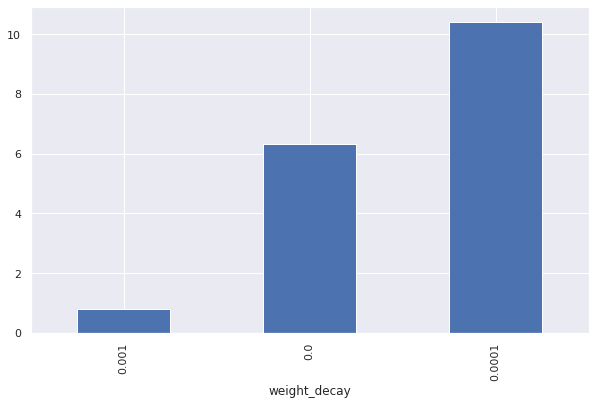

In [10]:
results.query("improvement > 0").groupby("weight_decay").improvement.max().sort_values().plot.bar()

<AxesSubplot:xlabel='dropout'>

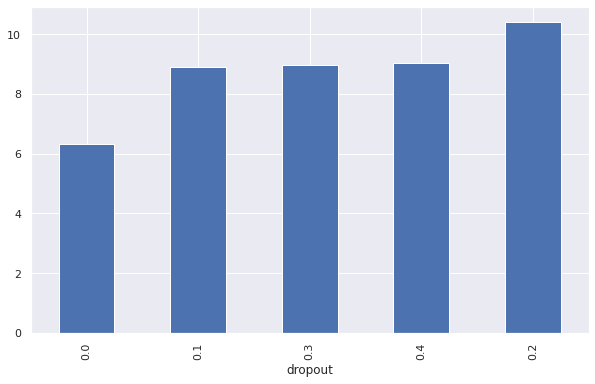

In [11]:
results.query("improvement > 0").groupby("dropout").improvement.max().sort_values().plot.bar()

<AxesSubplot:>

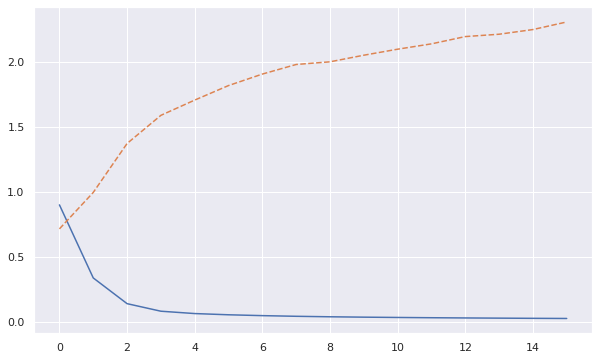

In [12]:
logs.query("experiment_id == '22717029_11'").train_loss.plot()
logs.query("experiment_id == '22717029_11'").dev_loss.plot(ls = "--")

In [13]:
results.query("experiment_id == '22697242_12'")\
[["experiment_id", "window", "window_size", "decoding", "weighting", "improvement"]]\
.sort_values(["window", "window_size", "decoding", "weighting"])\
.pivot(index = "experiment_id", 
       values = "improvement", 
       columns = ["window", "window_size", "decoding", "weighting"])

window        disjoint                      sliding                           \
window_size        50            100            50                             
decoding          beam greedy   beam greedy    beam                   greedy   
weighting          NaN    NaN    NaN    NaN    bell triangle uniform    bell   
experiment_id                                                                  
22697242_12      2.602  0.707  8.524  2.483   9.109      9.1   9.054  10.379   

window                          
window_size                     
decoding                        
weighting     triangle uniform  
experiment_id                   
22697242_12     10.397  10.278